# SAMPLE RUNTHROUGH

## PREPARE DATA

In [1]:
with open('data/names.txt') as f:
    names = f.readlines()
names = [name.strip() for name in names]

itos = {}
stoi = {}

itos[0]='.'
stoi['.']=0

letters=sorted(list(set("".join(names))))

for idx,letter in enumerate(letters):
    stoi[letter]=idx+1
    itos[idx+1]=letter

print(stoi)
print(itos)



{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [2]:
# Don't change these parameters, as they are used in the explanation in the SAMPLE RUNTHROUGH part
SAMPLE_CONTEXT_SIZE = 3
SAMPLE_LETTER_EMBEDDING_SIZE=2
SAMPLE_TRAINING_DATA_SIZE=5
SAMPLE_HIDDEN_LAYER_NEURONS=100

In [3]:
import torch

def generate_training_data(names,context_size=3,print_out=False):
    X = []
    Y = []
    for name in names:
        name = name + "."
        context = context_size * [0]
        if print_out:
            print(name)
        for ch in name:
            context_str = "".join([itos[idx] for idx in context])
            predict_str = ch
            if print_out:
                print(f"{context_str}-->{predict_str}")
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:]+[stoi[ch]]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X, Y

X,Y = generate_training_data(names[:3],3, True)



emma.
...-->e
..e-->m
.em-->m
emm-->a
mma-->.
olivia.
...-->o
..o-->l
.ol-->i
oli-->v
liv-->i
ivi-->a
via-->.
ava.
...-->a
..a-->v
.av-->a
ava-->.


In [4]:
X,Y = generate_training_data(names[:SAMPLE_TRAINING_DATA_SIZE],SAMPLE_CONTEXT_SIZE)

We have 32 examples with 3 context letters each

In [5]:
X.shape

torch.Size([32, 3])

In [6]:
Y.shape

torch.Size([32])

## START BUILDING THE NEURAL NETWORK

### ARCHITECTURE OF NEURAL NETWORK
![](./data/img/makemore_l2.png)

!ps in second layer ther is 6 rows and 100 cols

### CREATE LETTER EMBEDDINGS

Represent each letter in alpabeth with 2 dimensional embedding vector. Initialize the embedding vectors randomly.

In [7]:
C = torch.randn(27,SAMPLE_LETTER_EMBEDDING_SIZE).float()
C.shape

torch.Size([27, 2])

Create embeddings "emb" for all the training samples for each context word.       
The result: A tensor (multidimensional matrix) with dimensions | Train size * Context Size * Letter embedding Size |

Where 

- Train size : How many training examples our data has 
- Context size : How many previous letters we use to predict the next letter
- Letter embedding size : How many dimensions we use to model 1 letter

In [8]:
emb = C[X] 
# C is 27 * 2
# X is 32 * 3 where each value is a letter index from 0-27 
# We basically choose a 2 dimensional vector for each letter index in X
emb.shape

torch.Size([32, 3, 2])

Below is the first training sample context letters as 2 dimensional vectors

In [9]:
emb[0]

tensor([[ 1.0299, -0.0969],
        [ 1.0299, -0.0969],
        [ 1.0299, -0.0969]])

### CREATE NEURON WEIGHTS

Each neuron has weight for all context letter all dimensions


In [10]:
W1 = torch.randn([SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE,SAMPLE_HIDDEN_LAYER_NEURONS])
W1.shape

torch.Size([6, 100])

Let's create bias parameter as well

In [11]:
b1 = torch.randn(SAMPLE_HIDDEN_LAYER_NEURONS) 
b1.shape

torch.Size([100])

### SHAPE TRAINING DATA SO WE COULD MATRIX MULTIPLY IT WITH NEURONS

This means the training data rows need to have have as many columns as neurons take inputs.

**NOT WELL PERFORMING SAMPLE**

The unbind operation seems to take a particular dimension and remove it in a way that instead of that dimension you will have that dimension represented in multiple lists for each dimension. It allows us to do easy concatenation.

In [12]:
training_data = torch.cat(torch.unbind(emb,1),1) 

In [13]:
training_data.shape

torch.Size([32, 6])

**BETTER PERFORMING SAMPLE** 

View is a much faster operation compared to cat and bind because it does not need to use extra memory. It is also able to sort of unstack the tensor dimensions

In [14]:
(torch.eq(training_data, emb.view(-1,6)).all())

tensor(True)

emb.view(-1,6)

### FIRST PART OF FORWARD PROPAGATION

Here we flow the data through first 100 neurons. 

For each sample we now get 100 values. 


In [15]:
training_data = emb.view(-1,SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE) 
h = training_data @ W1 + b1
h.shape

torch.Size([32, 100])

### COMPLETE ONE TIME FORWARD PASS

We create second layer with softmax function. There will be 27 neurons,
each neuron output will be a probability for particular letter

In [16]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
logits = h.tanh() @ W2 + b2 
counts = logits.exp()
probs = counts/counts.sum(1,keepdim=True)


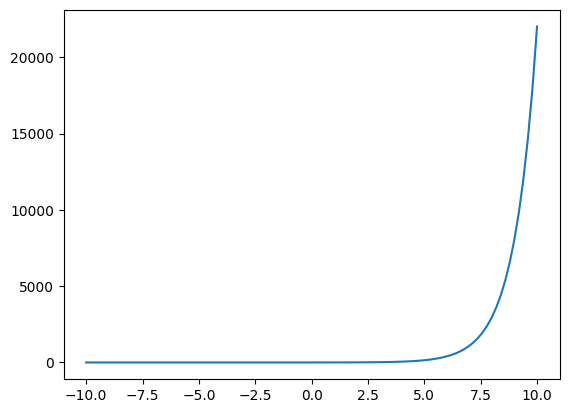

In [17]:
# Quick example of exponent function visualized

import matplotlib as plt

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10,10,100)

plt.plot(x,np.exp(x))


Check that for each training sample the probabilities will equal = 1

In [18]:
probs.sum(1,keepdim=True)[:10]

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

For each X get the probability for the right prediction. If it is low, the loglikelihood will return high loss

In [19]:
loss  = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [20]:
loss

tensor(16.2035)

## QUESTIONS


### QUESTION 1

- Are dimension mapping for each particular letter parameters in this neural network? 


### QUESTION 2

- If our dataset has 200 training examples. Each letter is mapped to 2 dimensions. We will have 100 neurons in middle layer and 27 neurons in the output layer. How many times for we update gradient for 1 character 1 dimension ?

## ANSWERS 


### ANSWER 1

- Yes, these are All dimensions for the 27 letters . These we will update in each training run to reduce loss. These parameters affect the multiplication with each neuron in the first hidden layer. 

### ANSWER 2 

Letter Dimension for one of the 27 layers is an instance shared among multiple training sample pairs. The cost function is calculated as comparison between all the training sample pairs. So if if specific word occurs in a training sample pair, then it's dimensions will also occur in the training sample pair which means it there is going to be a gradient update. 
In addition, the letter dimension will be input to 100 neurons. So for each neuron there willl be also gradient update based on that training sample pair. .    
- In total, anwswer is going to be TRAINING_SET_OCCURENCES * OUTPUT_NEURONS_FOR_LETTER_EMBEDDINGS which in this case is 200 * 100  . More info on my [YT explanation](https://www.youtube.com/watch?v=KUw20-24YNE&ab_channel=AndresNamm)

# MORE RESPECTABLE VERSION OF NEURAL NETWORK + TRAINING

Lets define some default hyperparameters

In [21]:
EMBEDDING_DIMENSION = 2
CONTEXT_SIZE = 3
TRAINING_SIZE = -1 # -1 means all data
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 30

Let us now generate new training data

In [22]:
X,Y = generate_training_data(names[:TRAINING_SIZE], context_size=CONTEXT_SIZE,print_out=False)

print(f"X shape {X.shape}")
print(f"Y shape {Y.shape}")

X shape torch.Size([228140, 3])
Y shape torch.Size([228140])


Initialize parameters

In [23]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,EMBEDDING_DIMENSION,generator=g) 
W1 = torch.randn(EMBEDDING_DIMENSION*CONTEXT_SIZE,HIDDEN_LAYER_SIZE,generator=g)
B1 = torch.randn(HIDDEN_LAYER_SIZE,generator=g) # Add to every neuron bias
W2 = torch.randn(HIDDEN_LAYER_SIZE,27,generator=g)
B2 = torch.randn(27) # Add to every neuron bias

params = [C,W1,B1,W2,B2]
param_count = sum([p.nelement()  for p in params])
print(f"Total parameters currently in NN {param_count}")

for p in params:
    p.requires_grad=True




Total parameters currently in NN 3481


## TRAINING WITH FULL DATA

In [24]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation
    h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    # manual method
    # counts = logits.exp()
    # probs = counts/counts.sum(1,keepdim=True)
    # loss += -probs[torch.arange(len(X)),Y].log().mean()
    loss = F.cross_entropy(logits, Y)

    print(f"Total loss currently is {loss}")
    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1#type:ignore

    if i > 3:
        print("This is too slow, let's implement the minibatch approach")
        break


Total loss currently is 19.19011878967285
Total loss currently is 16.573490142822266


Total loss currently is 15.311563491821289
Total loss currently is 14.380753517150879
Total loss currently is 13.567273139953613
This is too slow, let's implement the minibatch approach


## TRAINING WITH MINIBATCHES

In [25]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 10 == 0:
        print(f"Iteration {i}: Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1 #type: ignore



Iteration 0: Total loss currently is 12.276187896728516
Iteration 10: Total loss currently is 8.877606391906738


Iteration 20: Total loss currently is 7.204649448394775
Iteration 30: Total loss currently is 5.876865863800049
Iteration 40: Total loss currently is 5.493464946746826
Iteration 50: Total loss currently is 5.610097885131836
Iteration 60: Total loss currently is 5.696964740753174
Iteration 70: Total loss currently is 4.290135383605957
Iteration 80: Total loss currently is 4.192289352416992
Iteration 90: Total loss currently is 3.721163034439087


## TRYING TO FIND THE BEST LEARNING RATE

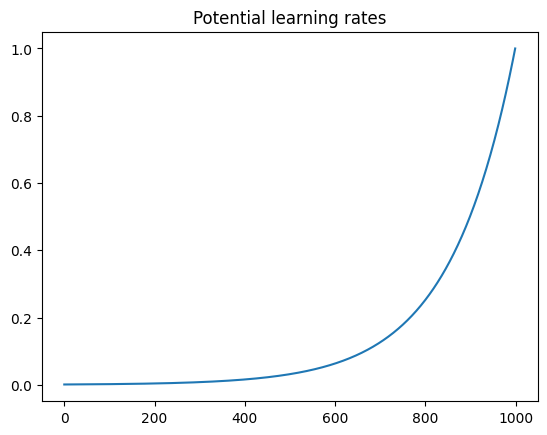

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

lre = torch.linspace(-3,-0,1000)
lr = 10 ** lre
plt.title("Potential learning rates")
plt.plot(lr)

In [27]:
lri = []
lossi = []

for i in range(1000):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 100==0:
        print(f"Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * lr[i]

    lri.append(lr[i])
    lossi.append(loss.item())


Total loss currently is 3.527292013168335
Total loss currently is 4.232468605041504


Total loss currently is 3.9166600704193115
Total loss currently is 4.014821529388428
Total loss currently is 3.6074116230010986
Total loss currently is 2.7780838012695312
Total loss currently is 2.962111711502075
Total loss currently is 3.0760738849639893
Total loss currently is 3.0650157928466797
Total loss currently is 7.22910737991333


We choose the learning rate from area where we see the loss is generally low. 
This method might not be mathematically super provable but visually here we actually find area where loss in general is low and gives us good estimation

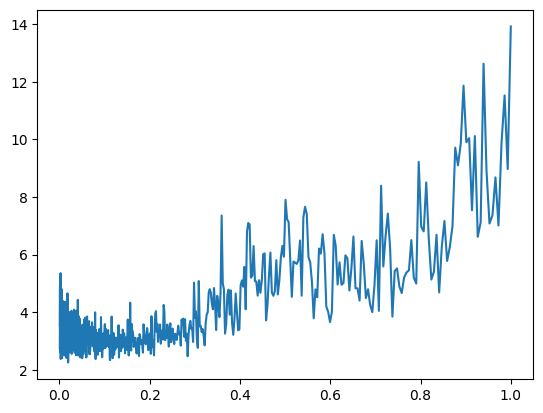

In [28]:
plt.plot(lri,lossi)

# FURTHER TUNING TRAINING TO GET LOWEST LOSS POSSIBLE SCORE

## MAKE THE TRAINING EVEN MORE PROPER

Here, I am running some sample experiments with different neural network hyperparameters to see what is the best performing. 
This is currently commented out because it seems to make my Python interpreter stop working after some rounds.

In general it seems bes performing is 

- Context size 4 
- Hidden layer size 150
- Letter embedding 3

In [29]:
# from makemore.prepare_data import generate_training_data
# from makemore.neural_network import NeuralNetwork, TrainingParams
# import matplotlib.pyplot as plt

# with open('data/names.txt', encoding='utf-8') as f:
#     names = f.readlines()
#     names = [name.strip() for name in names]

# def train_neural_network(context_size,hidden_layer_size,embedding_dimension,batch_size,epochs,learning_rate_func, print_flag=False):
#     X,Y = generate_training_data(names,context_size, False)
#     nn = NeuralNetwork(context_size=context_size,hidden_layer_neurons=hidden_layer_size,letter_embedding_dimensions=embedding_dimension,print_flag=print_flag)
#     training_params = TrainingParams(batch_size=batch_size,iterations=epochs,learning_rate=learning_rate_func)
#     nn.train(X,Y,training_params)
#     return nn

# epochs=1000
# neural_nets = []
# embedding_dimension=3

# for context_size in [3,4,5]:
#     print(f"Training with context size {context_size}")
#     nn = train_neural_network(context_size=context_size,hidden_layer_size=100,embedding_dimension=embedding_dimension,batch_size=30,epochs=epochs,learning_rate_func=lambda i: [0.1,0.01,0.001][i//450],print_flag=True)
#     neural_nets.append(nn)
#     print(f"Neural network {nn.name} final loss: {nn.losses[-1]}")

# for hidden_layer_size in [100,150,200]:
#     print(f"Training with hidden_layer_size {hidden_layer_size}")
#     nn = train_neural_network(context_size=4,hidden_layer_size=hidden_layer_size,embedding_dimension=embedding_dimension,batch_size=30,epochs=epochs,learning_rate_func=lambda i: [0.1,0.01,0.001][i//450],print_flag=True)
#     neural_nets.append(nn)
#     print(f"Neural network {nn.name} final loss: {nn.losses[-1]}")


# for nn in neural_nets:
#     plt.plot([(loss.item()) for loss in nn.losses[-8:]], label=nn.name, scaley=True )

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()

# min_loss_network = neural_nets[0]
# min_loss = neural_nets[0].losses[-1]
# for nn in neural_nets[1:]:
#     if nn.losses[-1] < min_loss:
#         min_loss = nn.losses[-1]
#         min_loss_network = nn

# print(f"Minimum loss network is {min_loss_network.name} with loss {min_loss}")

From this chart and final improvements it seems 

## MANUAL FINE TUNING WITH SMALL LEARNING RATE

In [30]:
from makemore.prepare_data import generate_training_data
from makemore.neural_network import NeuralNetwork, TrainingParams

with open('data/names.txt', encoding='utf-8') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

X,Y = generate_training_data(names,4)

nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True)


Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108


In [32]:
trainig_parameters = TrainingParams(iterations=100000,batch_size=30, learning_rate=lambda x: 0.1)
nn.train(X,Y,trainig_parameters)


Start training
Loss after 62124 epochs: 2.3644049167633057
Loss after 95457 epochs: 2.2931721210479736
Loss after 128790 epochs: 2.2478115558624268
Loss after 162123 epochs: 2.273219347000122
NN_4_150_3 loss:after 100000 epochs: 2.273219347000122


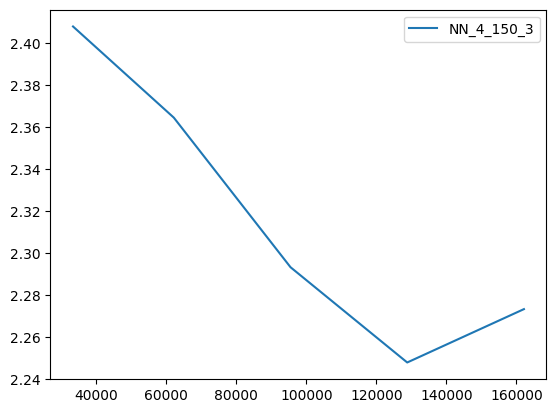

In [33]:
import matplotlib.pyplot as plt
len(nn.losses)
plt.plot([iteration for iteration in nn.loss_iterations[1:]],[loss.item() for loss in nn.losses[1:]], label=nn.name)
plt.legend()

Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 24.17488670349121
Loss after 34 epochs: 11.147116661071777
Loss after 67 epochs: 8.33547306060791
Loss after 100 epochs: 6.375205993652344
NN_4_150_3 loss:after 100 epochs: 6.375205993652344


[19, 1, 12, 1, 0]

# NAME GENERATION TEST WITH NN

In [34]:
nn.generate_name()

TypeError: can only concatenate list (not "int") to list

# TRAIN/DEV/TEST SET

In [ ]:
import random
random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

X_training,Y_training = generate_training_data(names[:n1])
X_validation,Y_validation = generate_training_data(names[n1:n2])
X_test,Y_test = generate_training_data(names[n2:])
